- Test 데이터의 cat, sub_cat 컬럼은 예측 시점의 정답을 암시하므로, 이를 사용하면 Data Leakage로 간주되어 감점 또는 실격

In [29]:
import pandas as pd
train= pd.read_csv(r'C:\Users\user\OneDrive\바탕 화면\22-23 컨퍼런스\train_pop_data.csv',encoding='cp949')
test = pd.read_csv(r'C:\Users\user\OneDrive\바탕 화면\22-23 컨퍼런스\test_pop_data.csv',encoding='cp949')

In [30]:
# target 변수 분리
target = train.pop('call_count')

train['tm'] = pd.to_datetime(train['tm'])
test['tm'] = pd.to_datetime(test['tm'])

### 기존 파생변수 유지

In [31]:
train['year'] = train['tm'].dt.year
train['month'] = train['tm'].dt.month
train['day'] = train['tm'].dt.day
train['weekday'] = train['tm'].dt.dayofweek

test['year'] = test['tm'].dt.year
test['month'] = test['tm'].dt.month
test['day'] = test['tm'].dt.day
test['weekday'] = test['tm'].dt.dayofweek

train['stn'] = train['stn'].astype(str)
test['stn'] = test['stn'].astype(str)

In [32]:
# 파생변수 생성

# 풍속 평균
train['wind_mean'] = (train['ws_ins_max'] + train['ws_max']) / 2

# 습도 범위
train['hm_range'] = train['hm_max'] - train['hm_min']

# 강수량 구간화
train['rn_day'] = train['rn_day'].apply(lambda x: 0 if x < 0 else x)
bins = [-0.1, 0, 10, 30, 70, train['rn_day'].max()]
labels = ['없음', '약한 비', '보통 비', '강한 비', '매우 강한 비']
train['rn_day_bin'] = pd.cut(train['rn_day'], bins=bins, labels=labels)

# 풍속 평균
test['wind_mean'] = (test['ws_ins_max'] + test['ws_max']) / 2

# 습도 범위
test['hm_range'] = test['hm_max'] - test['hm_min']

# 강수량 구간화
test['rn_day'] = test['rn_day'].apply(lambda x: 0 if x < 0 else x)
bins = [-0.1, 0, 10, 30, 70, test['rn_day'].max()]
labels = ['없음', '약한 비', '보통 비', '강한 비', '매우 강한 비']
test['rn_day_bin'] = pd.cut(test['rn_day'], bins=bins, labels=labels)

## 새로운 파생변수 추가

In [33]:
# 자연재해 여부
train['disaster_day'] = train['sub_cat'].isin(['자연재해','지원출동(풍수해']).astype(int)
test['disaster_day'] = test['sub_cat'].isin(['자연재해','지원출동(풍수해']).astype(int)
# 2020년 여부
train['is_covid_year'] = (train['year'] == 2020).astype(int)
test['is_covid_year'] = (test['year'] == 2020).astype(int)

In [34]:
# 지역 그룹 분류 기준 정의
coastal = ['해운대구', '수영구', '영도구', '중구', '동구', '서구', '남구']
urban = ['부산진구', '동래구', '연제구']
mountain = ['금정구', '기장군']
lowland = ['강서구', '북구', '사상구', '사하구']

# 각 지역 그룹에 해당하는지 여부를 이진 변수로 직접 생성
for df in [train, test]:
    df['region_coastal'] = df['address_gu'].isin(coastal).astype(int)
    df['region_urban'] = df['address_gu'].isin(urban).astype(int)
    df['region_mountain'] = df['address_gu'].isin(mountain).astype(int)
    df['region_lowland'] = df['address_gu'].isin(lowland).astype(int)

## cat/sub_cat 삭제
- 변수 중요도 낮은 address_city, rn_day_bin 삭제

In [35]:
del train['cat']
del test['cat']
del train['sub_cat']
del test['sub_cat']

In [36]:
del train['address_city']
del test['address_city']
del train['rn_day_bin']
del test['rn_day_bin']

In [40]:
del train['ws_ins_max']
del test['ws_ins_max']

In [37]:
train.columns

Index(['tm', 'address_gu', 'sub_address', 'stn', 'ta_max', 'ta_min',
       'ta_max_min', 'hm_min', 'hm_max', 'ws_max', 'ws_ins_max', 'rn_day',
       'population', 'old_population', '평균주거인구수', '평균직장인구수', '평균방문인구수', 'year',
       'month', 'day', 'weekday', 'wind_mean', 'hm_range', 'disaster_day',
       'is_covid_year', 'region_coastal', 'region_urban', 'region_mountain',
       'region_lowland'],
      dtype='object')

## 수치형/범주형 처리 & 데이터 분할

In [10]:
# 수치형 처리
from sklearn.preprocessing import MinMaxScaler

num_cols = train.select_dtypes(include = ['int', 'float']).columns
date_cols = ['year', 'month', 'day', 'weekday']
cols = [x for x in num_cols if x not in date_cols]

scaler = MinMaxScaler()
train[cols] = scaler.fit_transform(train[cols])
test[cols] = scaler.transform(test[cols])

In [11]:
# 범주형 처리
cat_cols = ['address_gu', 'sub_address', 'stn']
train[cat_cols] = train[cat_cols].astype('category')
test[cat_cols] = test[cat_cols].astype('category')

In [42]:
X = train.drop(columns = ['tm'])

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, target, test_size = 0.2, random_state = 0)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((49416, 27), (12355, 27), (49416,), (12355,))

## 모델링

In [27]:
## optuna
import optuna
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error
import numpy as np

def objective(trial):
    # 튜닝할 하이퍼파라미터 범위 정의
    params = {
        "loss_function": "Poisson",
        "random_state": 0,
        "verbose": 0,
        "iterations": trial.suggest_int("iterations", 300, 1500),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10),
        "border_count": trial.suggest_int("border_count", 32, 255),
    }

    # CatBoostRegressor 훈련
    model = CatBoostRegressor(**params, cat_features=cat_cols)
    model.fit(X_train, y_train)

    # 예측 및 성능 평가
    y_pred = model.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)  # Root Mean Squared Error

    return rmse

# Optuna Study 정의 및 실행
study = optuna.create_study(direction="minimize", study_name="CatBoost_Tuning")
study.optimize(objective, n_trials=50, timeout=600)  # 최대 50회 반복 or 10분 제한

# 최적 파라미터 출력
print("✅ Best Trial:")
print(study.best_trial)

print("✅ Best Parameters:")
print(study.best_params)


[I 2025-06-25 23:04:45,610] A new study created in memory with name: CatBoost_Tuning
[I 2025-06-25 23:06:11,874] Trial 0 finished with value: 1.2623936976201173 and parameters: {'iterations': 509, 'depth': 10, 'learning_rate': 0.0011482516042880613, 'l2_leaf_reg': 5.68691518970632, 'bagging_temperature': 0.6886998317254355, 'random_strength': 2.9900464169753076, 'border_count': 88}. Best is trial 0 with value: 1.2623936976201173.
[I 2025-06-25 23:08:13,165] Trial 1 finished with value: 0.9801562515779993 and parameters: {'iterations': 1172, 'depth': 6, 'learning_rate': 0.0038166161833928687, 'l2_leaf_reg': 6.178500608595952, 'bagging_temperature': 0.4169323820127707, 'random_strength': 2.6137903340558464, 'border_count': 211}. Best is trial 1 with value: 0.9801562515779993.
[I 2025-06-25 23:12:25,930] Trial 2 finished with value: 1.124983398337145 and parameters: {'iterations': 1235, 'depth': 10, 'learning_rate': 0.2095683128162685, 'l2_leaf_reg': 7.964986188695832, 'bagging_temperatur

✅ Best Trial:
FrozenTrial(number=1, state=1, values=[0.9801562515779993], datetime_start=datetime.datetime(2025, 6, 25, 23, 6, 11, 875475), datetime_complete=datetime.datetime(2025, 6, 25, 23, 8, 13, 165167), params={'iterations': 1172, 'depth': 6, 'learning_rate': 0.0038166161833928687, 'l2_leaf_reg': 6.178500608595952, 'bagging_temperature': 0.4169323820127707, 'random_strength': 2.6137903340558464, 'border_count': 211}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=1500, log=False, low=300, step=1), 'depth': IntDistribution(high=10, log=False, low=4, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0.001, step=None), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'random_strength': FloatDistribution(high=10.0, log=False, low=1e-09, step=None), 'border_count': IntDistribution(high=255, log=False,

In [43]:
# 최종 적용 모델

from catboost import CatBoostRegressor

# 최적 하이퍼파라미터를 적용한 모델
cat_model = CatBoostRegressor(
    loss_function='Poisson',
    iterations=1172,
    depth=6,
    learning_rate=0.0038166161833928687,
    l2_leaf_reg=6.178500608595952,
    bagging_temperature=0.4169323820127707,
    random_strength=2.6137903340558464,
    border_count=211,
    cat_features=cat_cols,
    random_state=0,
    verbose=100
)

In [44]:
cat_model.fit(X_train, y_train)
y_pred = cat_model.predict(X_val)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

result1 = mean_absolute_error(y_val, y_pred)
result2 = root_mean_squared_error(y_val, y_pred)
result3 = r2_score(y_val, y_pred)

print('MAE: ', result1)
print('RMSE: ', result2)
print('R2: ', result3)

0:	learn: 0.9992474	total: 67.3ms	remaining: 1m 18s
100:	learn: 0.9417885	total: 6.87s	remaining: 1m 12s
200:	learn: 0.9087567	total: 13.9s	remaining: 1m 7s
300:	learn: 0.8897065	total: 21.3s	remaining: 1m 1s
400:	learn: 0.8786329	total: 28.3s	remaining: 54.3s
500:	learn: 0.8711150	total: 35.4s	remaining: 47.5s
600:	learn: 0.8659324	total: 46s	remaining: 43.7s
700:	learn: 0.8623014	total: 57.5s	remaining: 38.6s
800:	learn: 0.8596692	total: 1m 5s	remaining: 30.6s
900:	learn: 0.8577101	total: 1m 14s	remaining: 22.3s
1000:	learn: 0.8562361	total: 1m 22s	remaining: 14s
1100:	learn: 0.8550050	total: 1m 30s	remaining: 5.82s
1171:	learn: 0.8542783	total: 1m 36s	remaining: 0us
MAE:  0.43791311060469523
RMSE:  0.9798709699960627
R2:  0.452304557627236


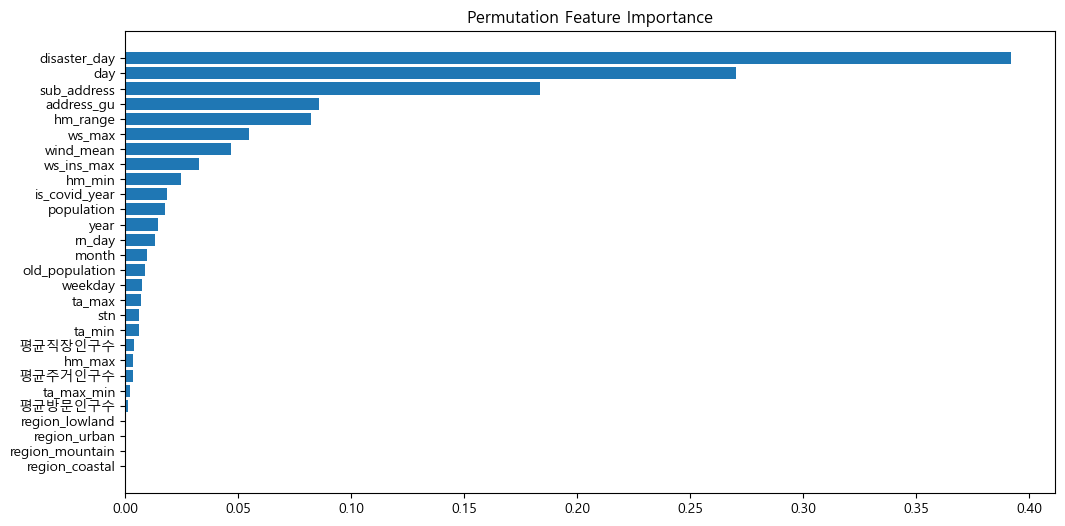

In [15]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우의 기본 한글 폰트
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'  # 리눅스, Colab 등

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(cat_model, X_val, y_val, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(12, 6))
plt.barh(X_val.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance")
plt.show()

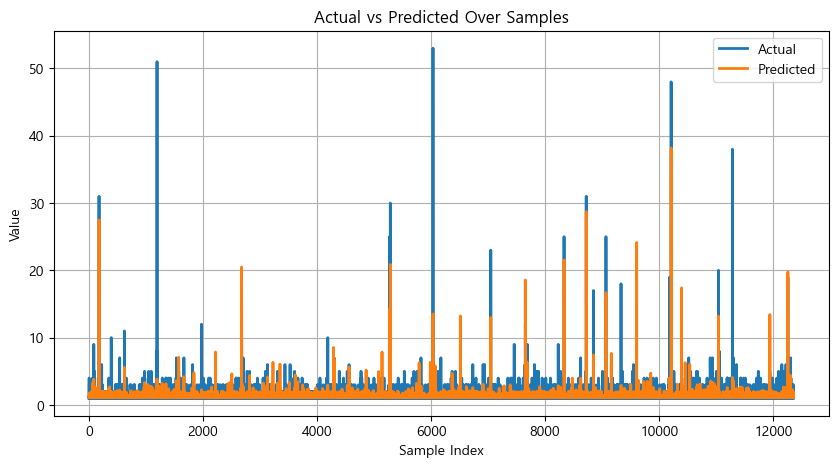

In [16]:
import matplotlib.pyplot as plt

# 실제 값 vs 예측값 산점도 
# 빨간 대각선 위에 점들이 몰려있을수록 모델이 잘 예측한 것

plt.figure(figsize=(10,5))
plt.plot(range(len(y_val)), y_val, label='Actual', linewidth=2)
plt.plot(range(len(y_pred)), y_pred, label='Predicted', linewidth=2)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Over Samples')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# 저장
import numpy as np
X_test = test.drop(columns = ['tm'])
pred = cat_model.predict(X_test)
pred = np.round(pred).astype(int)

test['call_count'] = pred
test_group = test.groupby(
    ['tm', 'address_gu', 'sub_address'],
    observed=True  # 또는 observed=False
)['call_count'].sum().reset_index()

test_group = test_group.rename(columns={
    'tm': 'TM'
})

sub = pd.read_csv(r'C:\Users\user\OneDrive\바탕 화면\22-23 컨퍼런스\test_call119.csv', encoding = 'cp949')
sub['TM'] = pd.to_datetime(sub['TM'], format='%Y%m%d')

submit = pd.merge(
    sub,
    test_group,
    how='left',
    on=['TM', 'address_gu', 'sub_address']
)
sub['call_count'] = submit['call_count_y']
sub['call_count'].value_counts()

call_count
1     6816
2     2081
3      359
4      228
6       76
8       21
5       12
9        3
10       2
7        2
11       1
Name: count, dtype: int64

In [46]:
# 기본모델 optuna
sub.to_csv('final\\250237_0627.csv', index = False, encoding = 'cp949')

# shap

In [47]:
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우의 기본 한글 폰트
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'  # 리눅스, Colab 등

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지


In [48]:
## shap 구현
import shap

# Tree 기반 모델: TreeExplainer 사용
explainer = shap.TreeExplainer(cat_model) 

# SHAP 값 계산 (X_train은 학습 데이터의 feature set)
shap_values = explainer.shap_values(X_train)


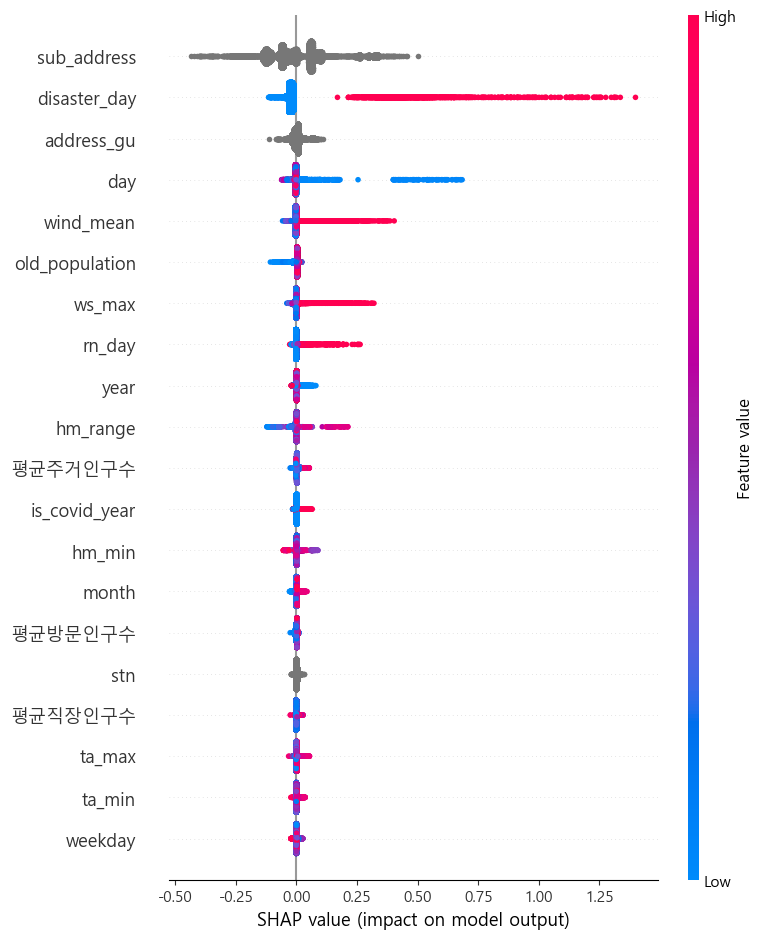

In [50]:
# 요약 플롯 (전체 feature 영향도)
shap.summary_plot(shap_values, X_train)

In [27]:
# SHAP 값 계산 (X_train은 학습 데이터의 feature set)
shap_values = explainer.shap_values(X_test)
shap_values = explainer(X_test)  # shap_values.values도 가능

C:\Users\user\AppData\Local\Temp\ipykernel_26444\3528899167.py:17: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
C:\Users\user\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


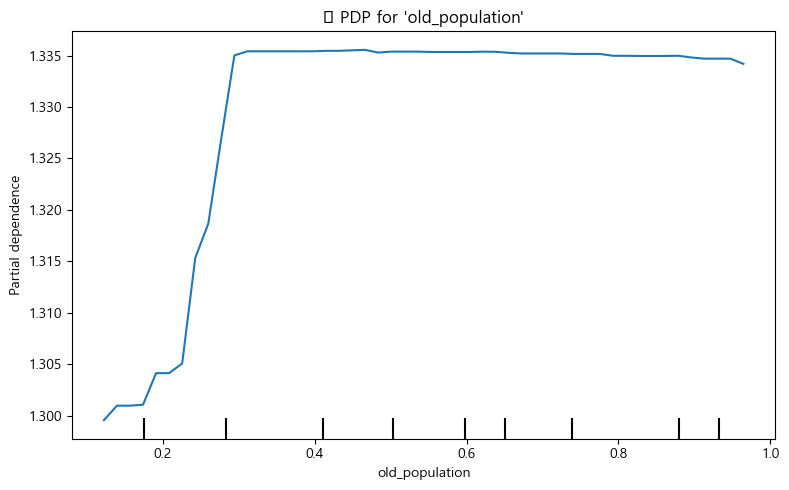

In [32]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 'old_population'에 대한 Partial Dependence Plot
features_to_plot = ['old_population']

fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(
    cat_model,       # 최종 학습한 CatBoost 모델
    X_val,           # 검증용 데이터
    features_to_plot,
    grid_resolution=50,
    ax=ax
)

plt.title("📈 PDP for 'old_population'")
plt.tight_layout()
plt.show()

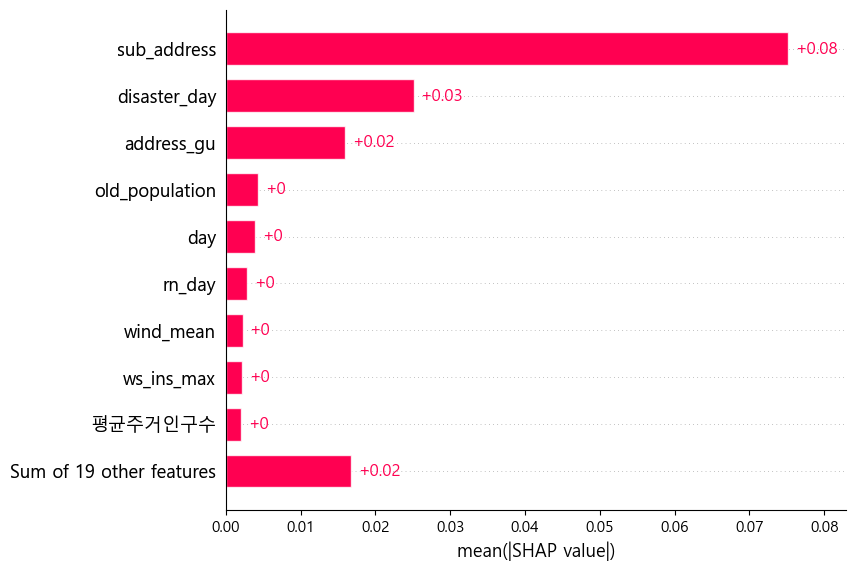

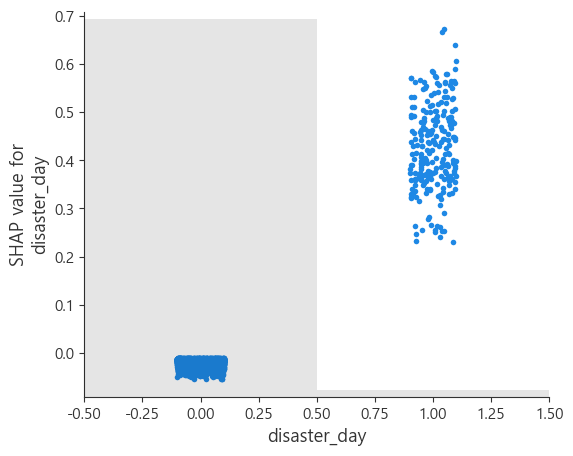

In [59]:
shap.plots.bar(shap_values, max_display=10)  # 절대값 기준 중요도만 보기
shap.plots.scatter(shap_values[:, "disaster_day"]) 

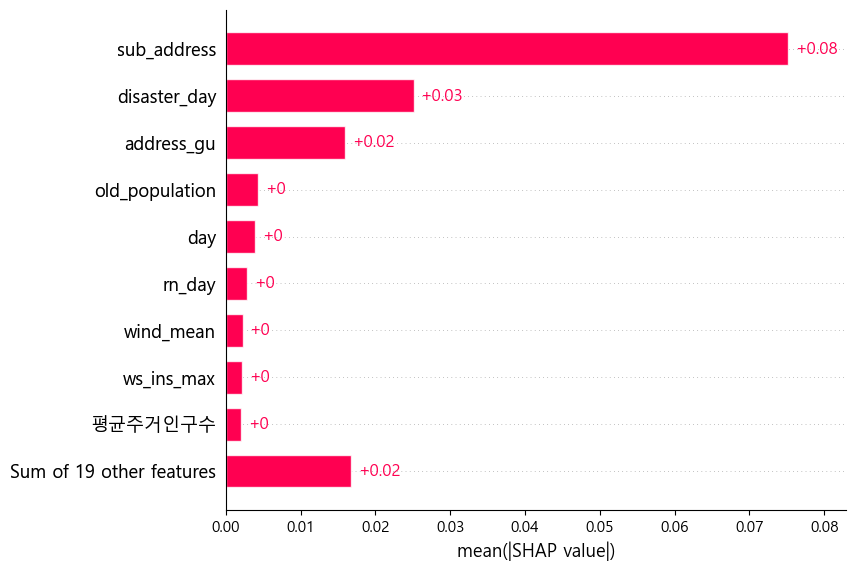

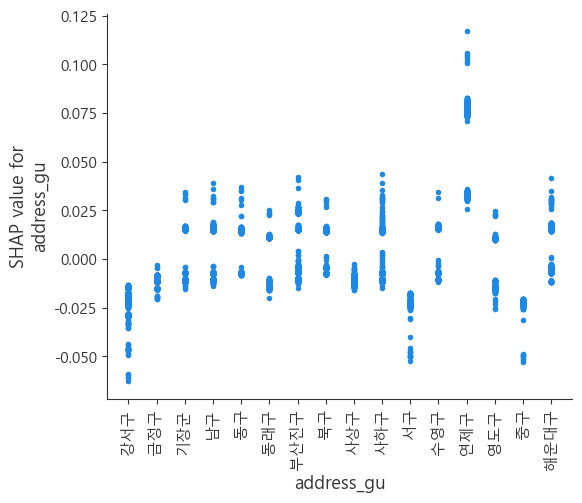

In [30]:
shap.plots.bar(shap_values, show=False)
shap.dependence_plot("address_gu", shap_values.values, X_test, interaction_index=None)